# Загрузка необходимых библиотек

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import zipfile
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# прописываем путь к архиву
zip_file = '/content/drive/MyDrive/DS_identity_emotions/input_data/redact_clean.zip'

# распакуем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [ ]:
# определим папки с данными, теперь итоговые изображения находятся в папке redact
train_dir = Path().parent / "redact"

train_anger_dir = train_dir / 'anger'
train_contempt_dir = train_dir / 'contempt'
train_disgust_dir = train_dir / 'disgust'
train_fear_dir = train_dir / 'fear'
train_happy_dir = train_dir / 'happy'
train_neutral_dir = train_dir / 'neutral'
train_sad_dir = train_dir / 'sad'
train_surprise_dir = train_dir / 'surprise'
train_uncertain_dir = train_dir / 'uncertain'

In [ ]:
def show_catsdogs(images, labels, predicted_labels=None, row=False, title=""):
    '''Функция для отображения изображений'''
    names = {0: "anger", 1: "contempt", 2: "disgust", 3: "fear", 4: "happy", 
             5: "neutral", 6: "sad", 7: "surprise", 8: "uncertain"}
    fig = plt.figure(figsize=(10, 3 if row else 10))
    st = fig.suptitle(title, fontsize="x-large")
    n = 5 if row else 16
    for i in range(n):
        if not row:
            plt.subplot(4,4, i+1)
        else:
            plt.subplot(1,5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[np.argmax(labels[i])]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[np.argmax(labels[i])]}")

Согласно правилам дипломного проекта: "Разрешается использовать предварительно обученные сети только на датасете ImageNet. Приветствуется использование архитектурных сверточных нейросетей, разобранных во время теоретических занятий."

Пробовал использовать U-Net, но время инференса составило свыше 500 мс, что не вписывается в наши критерии выборки. Максимальное время инференса может быть 333 мс.

#В качестве архитектуры нейронных сетей, выберем одну из тех, которые мы проходили:</br>
1)	mobileNetV2</br>
2)	VGG 19</br>
3)	ResNet50

#mobileNetV2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Подготовка входных данных

In [ ]:
BATCH_SIZE = 128

In [ ]:
image_gen_no_aug = ImageDataGenerator(rescale=1./255, validation_split=0.2)
sample_no_aug = image_gen_no_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(128,128),
                                                     class_mode='categorical',
                                                     subset = "training",
                                                     seed=123
                                                     )

Found 38569 images belonging to 9 classes.


In [ ]:
# а теперь мы попросим его изменять изображение на лету, добавляя небольшие повороты + отражения по горизонтали
image_gen_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,  # максимальный угол поворота
    horizontal_flip=True, # случайное отражение по горизонтали
    fill_mode="nearest", # чем заполнять пробелы
    validation_split=0.2  # соотношение тренировочных/валидационных данных = 0.8/0.2
    ) 



train_data_gen = image_gen_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                   directory=train_dir,
                                                   shuffle=True,
                                                   target_size=(128,128),
                                                   class_mode='categorical',
                                                   subset = "training",
                                                   seed = 123)  # 80%

val_data_gen = image_gen_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=train_dir,
                                                 shuffle=False,
                                                 target_size=(128,128),
                                                 class_mode='categorical',
                                                 subset = "validation",
                                                 seed = 123)  # 20%


Found 38569 images belonging to 9 classes.
Found 9639 images belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


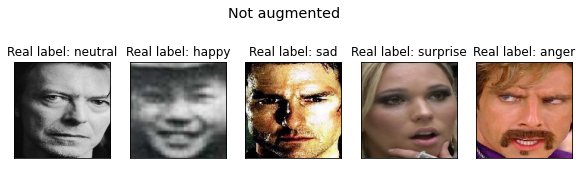

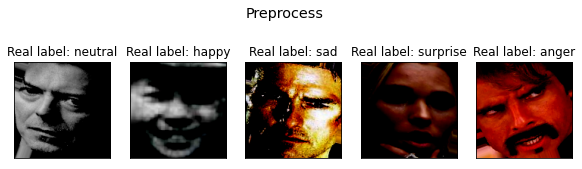

In [ ]:
sample_images, sample_labels = next(sample_no_aug)
show_catsdogs(sample_images, sample_labels, row=True, title="Not augmented")
sample_images, sample_labels = next(train_data_gen)
show_catsdogs(sample_images, sample_labels, row=True, title="Preprocess")

##Загрузка архитектуры модели, инициализируем веса обученные на датасете ImageNet

In [ ]:
IMG_SHAPE = (128, 128, 3)
# базовая модель -- MobileNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False # замораживаем всю базовую модель

9420800/9406464 [==============================] - 0s 0us/step


Попробуем сначала взять архитектуру исходную, не изменяя веса. В конце сети добавим Dense слой на 9 нейронов - кол-во классов, обучим его и посмотрим графически точность на валидационной и тестовой выборке.

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(9, activation='softmax')  # 9 - кол-во классов
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 9)                 11529     
                                                                 
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


###Замерим время инференса

In [ ]:
sample_images, sample_labels = next(val_data_gen)
test_img = sample_images[0][None,...]
test_img.shape

(1, 128, 128, 3)

In [ ]:
%%time

predictions = model.predict(test_img)

CPU times: user 101 ms, sys: 3.3 ms, total: 105 ms
Wall time: 102 ms


In [ ]:
%%timeit -n 10 -r 10

predictions = model.predict(test_img)

10 loops, best of 10: 62.9 ms per loop


##Время инференса удовлетворяет условию задачи, дальше приступим к обучению модели и тестированию

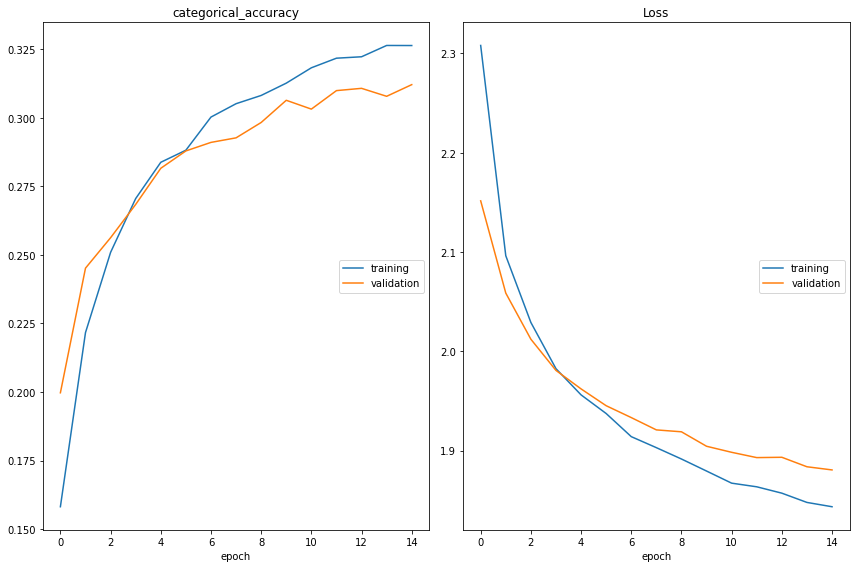

categorical_accuracy
	training         	 (min:    0.158, max:    0.326, cur:    0.326)
	validation       	 (min:    0.200, max:    0.312, cur:    0.312)
Loss
	training         	 (min:    1.843, max:    2.308, cur:    1.843)
	validation       	 (min:    1.881, max:    2.152, cur:    1.881)
302/302 [==============================] - 412s 1s/step - loss: 1.8434 - categorical_accuracy: 0.3263 - val_loss: 1.8805 - val_categorical_accuracy: 0.3121


In [ ]:
EPOCHS = 15
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

In [ ]:
model.save('./model_mobilenetv2_one_dense/1')

INFO:tensorflow:Assets written to: ./model_mobilenetv2_one_dense/1/assets


INFO:tensorflow:Assets written to: ./model_mobilenetv2_one_dense/1/assets


In [ ]:
!zip -r model_mobilenetv2_one_dense.zip model_mobilenetv2_one_dense

  adding: model_mobilenetv2_one_dense/ (stored 0%)
  adding: model_mobilenetv2_one_dense/1/ (stored 0%)
  adding: model_mobilenetv2_one_dense/1/saved_model.pb (deflated 91%)
  adding: model_mobilenetv2_one_dense/1/assets/ (stored 0%)
  adding: model_mobilenetv2_one_dense/1/keras_metadata.pb (deflated 96%)
  adding: model_mobilenetv2_one_dense/1/variables/ (stored 0%)
  adding: model_mobilenetv2_one_dense/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model_mobilenetv2_one_dense/1/variables/variables.index (deflated 76%)


In [ ]:
model.save('/content/drive/MyDrive/DS_identity_emotions/model/model_mobilenetv2_one_dense')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS_identity_emotions/model/model_mobilenetv2_one_dense/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS_identity_emotions/model/model_mobilenetv2_one_dense/assets


Разморозим все веса и обучим всю архитектуру.

In [ ]:
IMG_SHAPE = (128, 128, 3)
# базовая модель -- MobileNet
all_base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
all_base_model.trainable = True # размораживаем всю базовую модель

In [ ]:
model_all = tf.keras.Sequential([
  all_base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(9, activation='softmax')  # 9 - кол-во классов
])

model_all.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

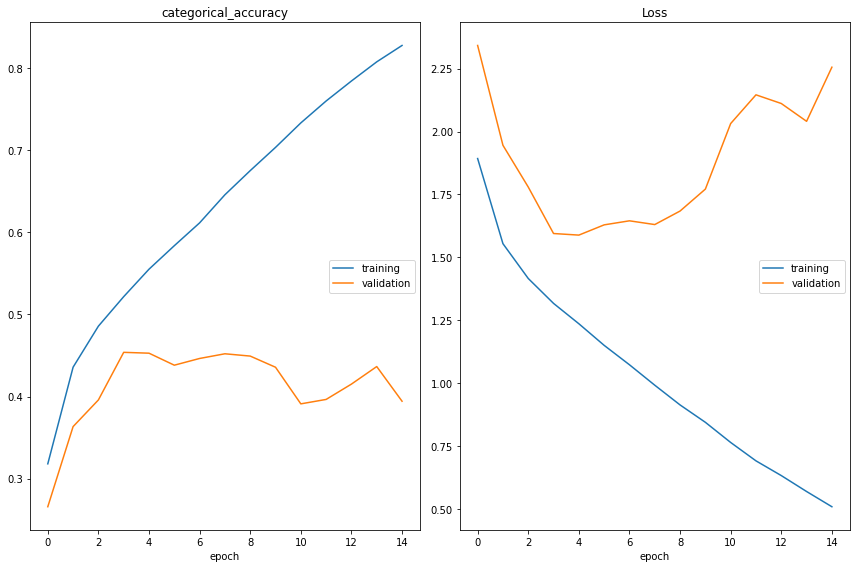

categorical_accuracy
	training         	 (min:    0.318, max:    0.828, cur:    0.828)
	validation       	 (min:    0.266, max:    0.454, cur:    0.394)
Loss
	training         	 (min:    0.510, max:    1.893, cur:    0.510)
	validation       	 (min:    1.589, max:    2.342, cur:    2.255)
302/302 [==============================] - 418s 1s/step - loss: 0.5095 - categorical_accuracy: 0.8277 - val_loss: 2.2555 - val_categorical_accuracy: 0.3943


In [ ]:
EPOCHS = 15
history_all = model_all.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

#Вывод:</br>
Использовались изображения обрезанные по Bounding box.</br></br>
С целью расширения вариативности входных данных - была проведена аугментация. Увеличивать, уменьшать и сдвигать изображения - не имеет смысла, т.к. они обрезаны по границе лица. В качестве вариации было задано: поворот - не более чем на 20 градусов и отражение по горизонтали.</br></br>
Модель: **MobileNetV2** - дает гораздо лучшие прогнозы, при условии обучения всех весов модели.</br>
Максимально достигнутая точность на валидационных данных: 0.454.</br>
Среднее время инференса: 62.9 мс.